In [1]:
import numpy as np
import torch
import torch.nn as nn

from IPython.display import clear_output

from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
from torchvision.datasets import MNIST
import torchvision.transforms as T

from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans

In [9]:
# nets
from autoencoders import StackedAutoEncoder, StackedDenoisingAutoEncoder
from deepclustering import DEC, IDEC, IDEC_loss
from utils import cluster_acc, predict_cluster_accuracy # hungarian algorithm

# dataset&train_cycles
from train_val import train, evaluate

# visualization
from visualization import plot_stats, plot_stats_dec, plot_stats_idec


In [3]:
class EmbeddingsDataset(Dataset):
    def __init__(self, features, text, labels, train):
        assert len(features) == len(text) == len(labels)
        # self.features = features
        self.labels = labels.tolist()
        self.text = text


        embeddings_ds = TensorDataset(
            features, 
            labels
        ) 
        train_idx, val_idx = train_test_split(
            list(range(len(embeddings_ds))), test_size=.1, shuffle=True
        )
        if train == -1:
            self.ds = embeddings_ds
        else:
            self.ds = Subset(embeddings_ds, train_idx) if train else Subset(embeddings_ds, val_idx)

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, index):
        data = self.ds[index][0]
        _class = self.ds[index][1]
        return (data, _class)

    def get_text_by_labels(self, lbl):
        _dict = {self.labels[i]: self.text[i] for i in range(len(self.labels))}

        return np.vectorize(_dict.get)(lbl) if isinstance(lbl, (list, np.ndarray)) else _dict[lbl]



In [4]:
txt_labels = np.load('../bert_embeddings/emb_txt_labels.npy', allow_pickle=True)

num_labels = torch.Tensor(
    np.load('../bert_embeddings/emb_num_labels.npy')
)

embdict = np.load('../bert_embeddings/embdict.npy', allow_pickle=True).item()
embeddings = torch.Tensor(embdict['max_pooling__identity']) # take 'max_pooling__identity' as default example

In [5]:
train_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=True)
valid_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=False)
full_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=-1)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=1024, shuffle=False, num_workers=0, pin_memory=True)
static_loader =  DataLoader(train_dataset, batch_size=256, pin_memory=False, shuffle=False)

## Train&Valid cycle

In [6]:
def whole_train_valid_cycle(
    model, scheduler, optimizer, loss_fn, device, title,
    num_epochs:int = 100, 
    patience_threshold:tuple = None,
    save_best_params_as:str = None
):
    train_loss_history, valid_loss_history = [], []
    
    best_valid_loss = np.inf
    patience = 0

    train_acc_history, train_nmi_history, train_ari_history = [], [], []
    val_acc_history, val_nmi_history, val_ari_history = [], [], []
    
    if type(model) == IDEC:
        train_rec_loss_history, train_cl_loss_history = [], []

    for epoch in range(num_epochs):

        if isinstance(model, DEC):

            train_loss, train_y, train_y_pred, = train(model, train_loader, optimizer, loss_fn, device, static_loader)
            valid_loss, val_targets, val_predicted = evaluate(model, valid_loader, loss_fn, device)
            
            if type(model) == IDEC:

                train_rec_loss, train_cl_loss = train_loss['rec'], train_loss['clust']
                train_loss = train_loss['total']
                
                
                train_rec_loss_history.append(train_rec_loss)
                train_cl_loss_history.append(train_cl_loss)
                

            train_acc = cluster_acc(train_y, train_y_pred)
            train_nmi = normalized_mutual_info_score(train_y, train_y_pred)
            train_ari = adjusted_rand_score(train_y, train_y_pred)

            train_acc_history.append(train_acc)
            train_nmi_history.append(train_nmi)
            train_ari_history.append(train_ari)

            val_acc = cluster_acc(val_targets, val_predicted)
            val_nmi = normalized_mutual_info_score(val_targets, val_predicted)
            val_ari = adjusted_rand_score(val_targets, val_predicted)

            val_acc_history.append(val_acc)
            val_nmi_history.append(val_nmi)
            val_ari_history.append(val_ari)
        
 
        elif isinstance(model, StackedAutoEncoder):
            train_loss = train(model, train_loader, optimizer, loss_fn, device)
            valid_loss = evaluate(model, valid_loader, loss_fn, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        
        print('patience:', patience)
        if patience_threshold[0] is not None and len(valid_loss_history)>1:
            if round(valid_loss_history[-2], patience_threshold[1]) \
            == round(valid_loss, patience_threshold[1]):
                patience += 1
            else:
                patience = 0

            if patience == patience_threshold[0]:
                print('Training stopped. Patience threshold was reached')
                break


        clear_output(wait=True)
        

        if isinstance(model, DEC):
            if type(model) == DEC:
                plot_stats_dec(
                    train_loss_history, valid_loss_history, 
                    train_acc_history, train_nmi_history, train_ari_history,
                    val_acc_history, val_nmi_history, val_ari_history,
                    title,
                )
            if type(model) == IDEC:
                plot_stats_idec(
                    train_loss_history, valid_loss_history, 
                    train_rec_loss_history, 
                    train_cl_loss_history,
                    train_acc_history, train_nmi_history, train_ari_history,
                    val_acc_history, val_nmi_history, val_ari_history,
                    title,
                )

        elif isinstance(model, StackedAutoEncoder):
            plot_stats(
                train_loss_history, valid_loss_history,
                title
            )

            # scheduler only for autoencoder
            scheduler.step() if not scheduler == None else None


        if not save_best_params_as == None:
            if valid_loss < best_valid_loss: 
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), save_best_params_as)
                print(f"Model parameters saved to '{save_best_params_as}'")                  
        
        

## Initialize

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

cuda:0
NVIDIA GeForce GTX 1060 with Max-Q Design


### Getting baseline KMeans score

In [8]:
km_baseline = KMeans(n_clusters=7, random_state=0, n_init=20).fit_predict(embeddings)

cluster_acc(
    num_labels.numpy(),
    km_baseline
)

0.544923821728606

## Run Autoencoder for every type of embedding

In [ ]:
# initialize model with parameters described in Subakti et al. (2022)
loss_fn = nn.MSELoss()
model = StackedDenoisingAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.02)

optimizer = Adam(model.parameters(), lr=1e-3, )
# optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=100) 

# torch.manual_seed(0)
whole_train_valid_cycle(
    model, 
    scheduler,
    optimizer,
    loss_fn,
    num_epochs = 500, 
    device = device,
    patience_threshold = (10,3),
    # save_best_params_as = './ae_weights/bertemb_train_1.pt',
    title="AutoEncoder BERT embeddings 'max_pooling__identity'\n train&valid MSE"
)

## Run DEC

#### num. 1 'max_pooling__standard'

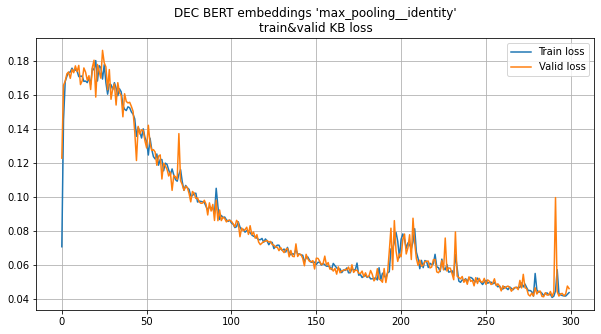

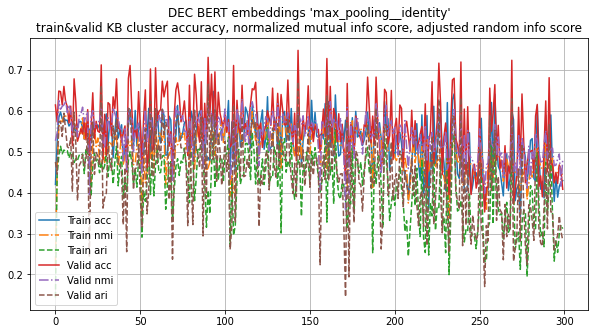

In [26]:
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.0)
model.load_state_dict(torch.load(r'./ae_weights/bertemb_train_1.pt'))

dec = DEC(autoencoder = model, n_clusters=7)
loss_fn = nn.KLDivLoss(reduction='batchmean')

optimizer = Adam(dec.parameters(), lr=1e-3)
# optimizer = SGD(dec.parameters(), lr=.0001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=60, gamma=0.01)

whole_train_valid_cycle(
    dec,
    scheduler,
    optimizer,
    loss_fn,
    num_epochs = 300,
    patience_threshold=10,
    device = device,
    # save_best_params_as='./weights/bertemb_dec_weights_1.pt',
    title="DEC BERT embeddings 'max_pooling__identity'\ntrain&valid KL"
)


In [27]:
print(
    dec.init_acc,
cluster_acc(
    num_labels.numpy(),
    dec(embeddings.to(device, dtype=torch.float32)).argmax(1).detach().cpu().numpy()
)
)

0.5200949367088608 0.39142816460202196


*Awful plots & performance! Let's start with another set of hyperparameters*

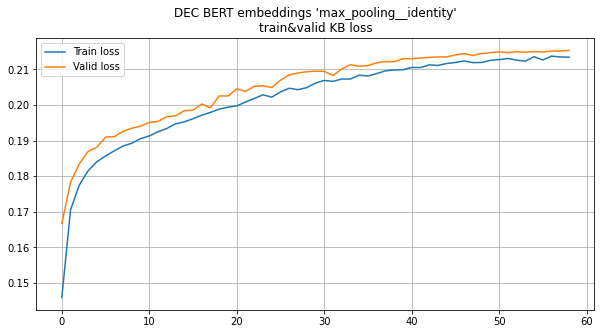

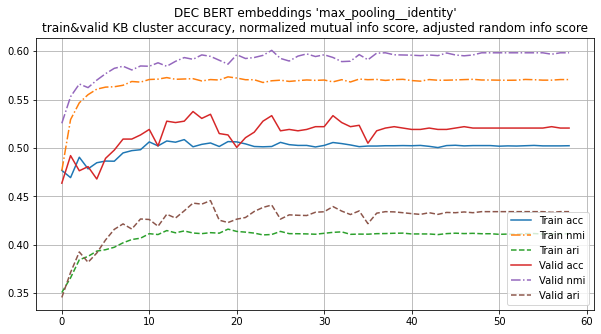

Evaluation: 100%|██████████| 1/1 [00:00<00:00, 38.20it/s]

patience: 9
Training stopped. Patience threshold was reached
Fin train loss: 0.21342761397361756
Fin valid loss: 0.2152368724346161


In [32]:
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.0)
model.load_state_dict(torch.load(r'./ae_weights/bertemb_train_1.pt'))

dec = DEC(autoencoder = model, n_clusters=7)
loss_fn = nn.KLDivLoss(reduction='batchmean')

optimizer = Adam(dec.parameters(), lr=1e-4)
# scheduler = StepLR(optimizer, step_size=60, gamma=0.01)

whole_train_valid_cycle(
    dec,
    None,
    optimizer,
    loss_fn,
    num_epochs = 100,
    patience_threshold=10,
    device = device,
    save_best_params_as='./weights/bertemb_dec_weights_1',
    title="DEC BERT embeddings 'max_pooling__identity'\ntrain&valid KL"
)


In [33]:
print(
    dec.init_acc,
cluster_acc(
    num_labels.numpy(),
    dec(embeddings.to(device, dtype=torch.float32)).argmax(1).detach().cpu().numpy()
)
)

0.5207278481012658 0.5010679196924391


*Still awful. But encoder outputs seem to catch KMeans baseline score so maybe we shoould use normalized embeddings?*

### Lets continue our findings with normalized embeddings!

#### num. 2 'max_pooling__standard'

In [107]:
embeddings = torch.Tensor(embdict['max_pooling__standard'])

train_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=True)
valid_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=False)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=1024, shuffle=False, num_workers=0, pin_memory=True)

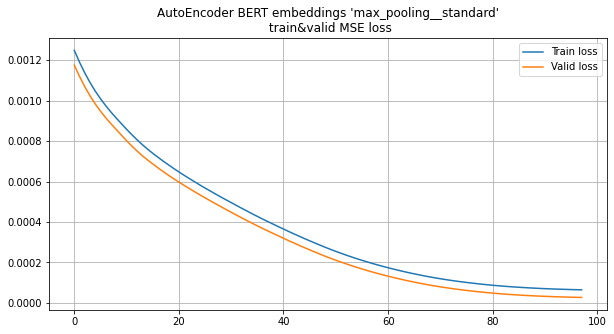

Model parameters saved to './ae_weights/bertemb_train_2.pt'


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 43.51it/s]

patience: 9
Training stopped. Patience threshold was reached
Fin train loss: 6.425237806979567e-05
Fin valid loss: 2.66311653831508e-05


In [115]:
loss_fn = nn.MSELoss()
model = StackedDenoisingAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.0)

optimizer = Adam(model.parameters(), lr=1e-6, )
scheduler = StepLR(optimizer, step_size=100, gamma=.1) # 60~=20000/256

# torch.manual_seed(0)
whole_train_valid_cycle(
    model, 
    None,
    optimizer,
    loss_fn,
    num_epochs = 500, 
    device = device,
    patience_threshold = (10, 5),
    save_best_params_as = './ae_weights/bertemb_train_2.pt',
    title="AutoEncoder BERT embeddings 'max_pooling__standard'\n train&valid MSE"
)

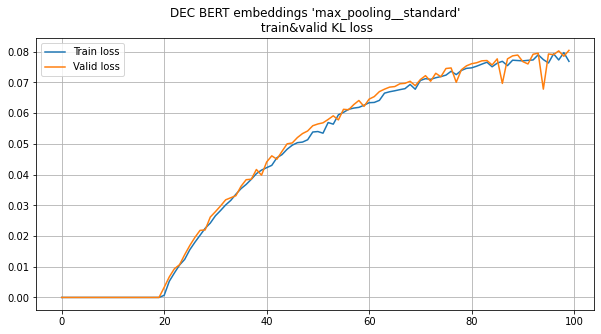

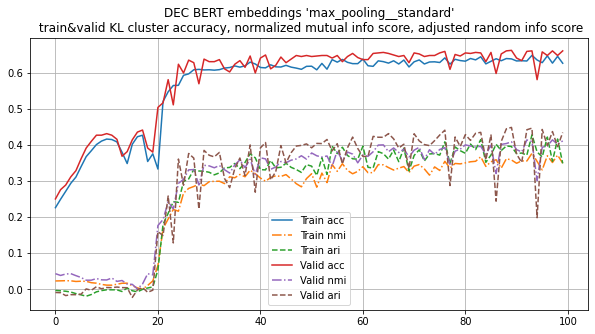

In [116]:
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.0)
model.load_state_dict(torch.load(r'./ae_weights/bertemb_train_2.pt'))

dec = DEC(autoencoder = model, n_clusters=7)
loss_fn = nn.KLDivLoss(reduction='batchmean')

optimizer = Adam(dec.parameters(), lr=1e-4)
# optimizer = SGD(dec.parameters(), lr=.0001, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=60, gamma=0.1)

whole_train_valid_cycle(
    dec,
    None,
    optimizer,
    loss_fn,
    num_epochs = 100,
    # patience_threshold=10,
    device = device,
    save_best_params_as='./weights/bertemb_dec_weights_2',
    title="DEC BERT embeddings 'max_pooling__standard'\n train&valid KL"
)


In [117]:
print(
    dec.init_acc,
cluster_acc(
    num_labels.numpy(),
    dec(embeddings.to(device, dtype=torch.float32)).argmax(1).detach().cpu().numpy()
)
)

0.21550632911392406 0.6465897764488111


*Despite contrintuitive behavior of loss curve, algoritm managed to find stable solution and beat the baseline performance. Autosaving weights not working properly here - don't forget to save them manually.*

In [119]:
torch.save(dec.state_dict(), './weights/bertemb_dec_weights_2')

#### num. 3 'max_pooling__layer'

In [123]:
embeddings = torch.Tensor(embdict['max_pooling__layer'])

train_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=True)
valid_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=False)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=1024, shuffle=False, num_workers=0, pin_memory=True)

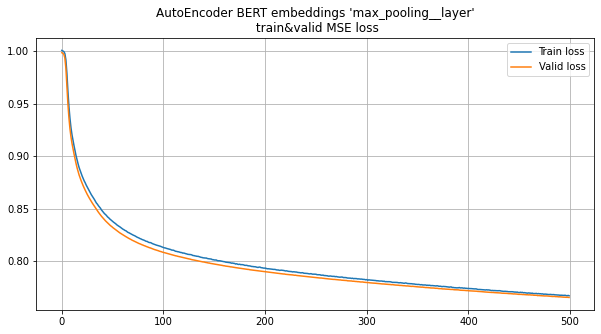

Model parameters saved to './ae_weights/bertemb_train_3.pt'


In [102]:
loss_fn = nn.MSELoss()
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.0)

optimizer = Adam(model.parameters(), lr=1e-5, )
scheduler = StepLR(optimizer, step_size=100, gamma=.1) # 60~=20000/256

# torch.manual_seed(0)
whole_train_valid_cycle(
    model, 
    None,
    optimizer,
    loss_fn,
    num_epochs = 500, 
    device = device,
    patience_threshold = (10, 4),
    save_best_params_as = './ae_weights/bertemb_train_3.pt',
    title="AutoEncoder BERT embeddings 'max_pooling__layer'\n train&valid MSE"
)

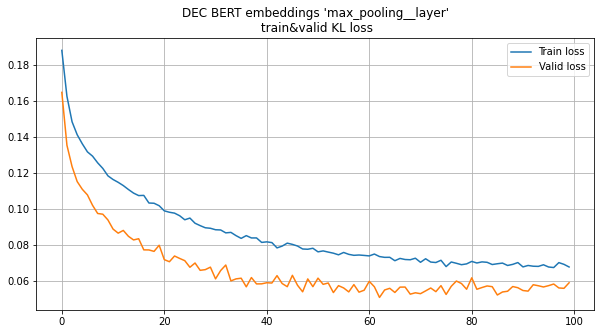

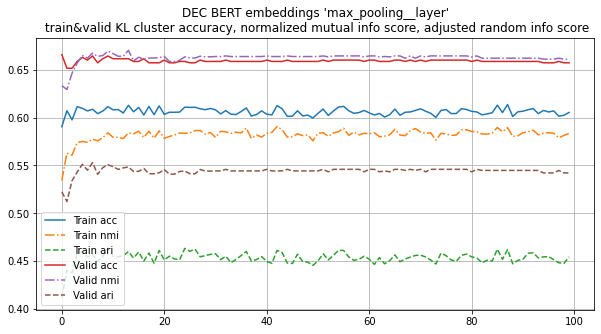

In [136]:
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.1)
model.load_state_dict(torch.load(r'./ae_weights/bertemb_train_3.pt'))

dec = DEC(autoencoder = model, n_clusters=7)
loss_fn = nn.KLDivLoss(reduction='batchmean')

optimizer = Adam(dec.parameters(), lr=1e-4)
# optimizer = SGD(dec.parameters(), lr=.0001, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=60, gamma=0.1)

whole_train_valid_cycle(
    dec,
    None,
    optimizer,
    loss_fn,
    num_epochs = 100,
    # patience_threshold=10,
    device = device,
    save_best_params_as='./weights/bertemb_dec_weights_3',
    title="DEC BERT embeddings 'max_pooling__layer'\n train&valid KL"
)


In [ ]:
dec.

In [137]:
print(
    dec.init_acc,
cluster_acc(
    num_labels.numpy(),
    dec(embeddings.to(device, dtype=torch.float32)).argmax(1).detach().cpu().numpy()
)
)

0.5700949367088608 0.6663818880820163


Looks much better than standard normalization. Adding dropout raises chances of stable performance

*Note: 'standard' normalization uses Denoising autoencoder, while 'layer' allowing stable performance. Anyway, final performance may vary +-5% because of good random seeds despite the learning curve behavior*

#### num. 4 'max_pooling__minmax'

In [139]:
embeddings = torch.Tensor(embdict['max_pooling__minmax'])

train_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=True)
valid_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=False)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=1024, shuffle=False, num_workers=0, pin_memory=True)

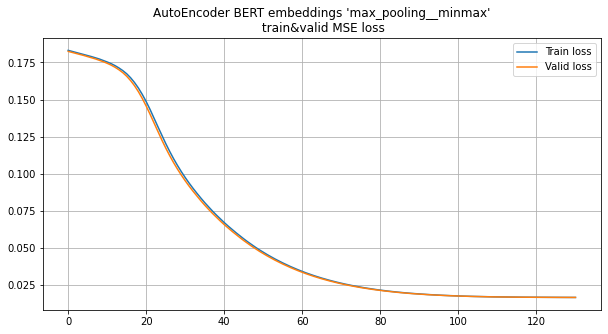

Model parameters saved to './ae_weights/bertemb_train_4.pt'


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 46.48it/s]

patience: 9
Training stopped. Patience threshold was reached
Fin train loss: 0.01645738333463669
Fin valid loss: 0.016458477824926376


In [141]:
loss_fn = nn.MSELoss()
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.0)

optimizer = Adam(model.parameters(), lr=1e-6, )
scheduler = StepLR(optimizer, step_size=100, gamma=.1) # 60~=20000/256

# torch.manual_seed(0)
whole_train_valid_cycle(
    model, 
    None,
    optimizer,
    loss_fn,
    num_epochs = 500, 
    device = device,
    patience_threshold = (10, 4),
    save_best_params_as = './ae_weights/bertemb_train_4.pt',
    title="AutoEncoder BERT embeddings 'max_pooling__minmax'\n train&valid MSE"
)

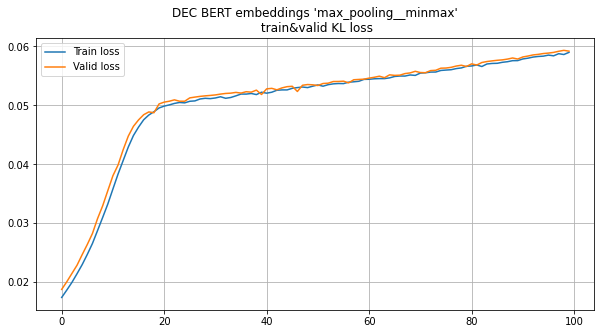

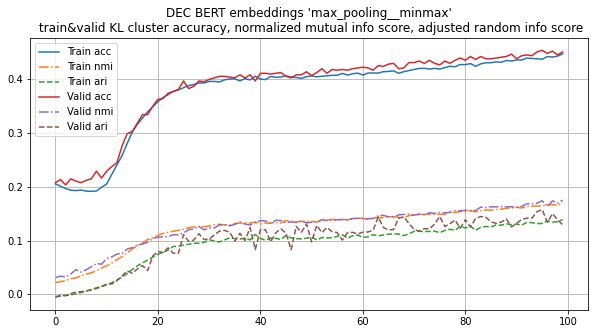

In [152]:
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.0)
model.load_state_dict(torch.load(r'./ae_weights/bertemb_train_4.pt'))

dec = DEC(autoencoder = model, n_clusters=7)
loss_fn = nn.KLDivLoss(reduction='batchmean')

optimizer = Adam(dec.parameters(), lr=1e-5)
# scheduler = StepLR(optimizer, step_size=60, gamma=0.1)

whole_train_valid_cycle(
    dec,
    None,
    optimizer,
    loss_fn,
    num_epochs = 100,
    # patience_threshold=10,
    device = device,
    save_best_params_as='./weights/bertemb_dec_weights_4',
    title="DEC BERT embeddings 'max_pooling__minmax'\n train&valid KL"
)


In [153]:
print(
    dec.init_acc,
cluster_acc(
    num_labels.numpy(),
    dec(embeddings.to(device, dtype=torch.float32)).argmax(1).detach().cpu().numpy()
)
)

0.2060126582278481 0.43984052399259577


*Bad initial guess despite smooth learning curve. Bad performance.*

#### num. 5 'mean_pooling__standard'

*Note: we skipping 'mean_pooling__identity' and 'mean_pooling__minmax' due to they bad performance*

In [169]:
embeddings = torch.Tensor(embdict['mean_pooling__standard'])

train_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=True)
valid_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=False)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=1024, shuffle=False, num_workers=0, pin_memory=True)

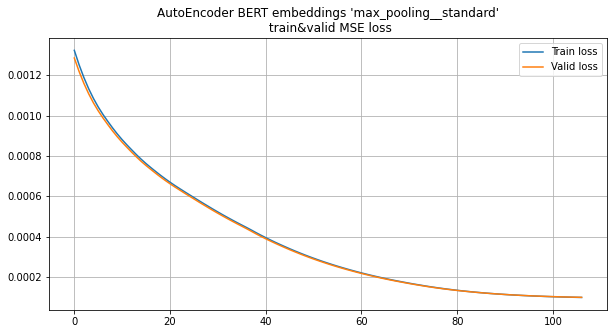

Model parameters saved to './ae_weights/bertemb_train_5.pt'


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 50.01it/s]

patience: 9
Training stopped. Patience threshold was reached
Fin train loss: 9.740654815686866e-05
Fin valid loss: 9.794975630939007e-05


In [170]:
loss_fn = nn.MSELoss()
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.0)

optimizer = Adam(model.parameters(), lr=1e-6, )
scheduler = StepLR(optimizer, step_size=100, gamma=.1) # 60~=20000/256

# torch.manual_seed(0)
whole_train_valid_cycle(
    model, 
    None,
    optimizer,
    loss_fn,
    num_epochs = 500, 
    device = device,
    patience_threshold = (10, 5),
    save_best_params_as = './ae_weights/bertemb_train_5.pt',
    title="AutoEncoder BERT embeddings 'max_pooling__standard'\n train&valid MSE"
)

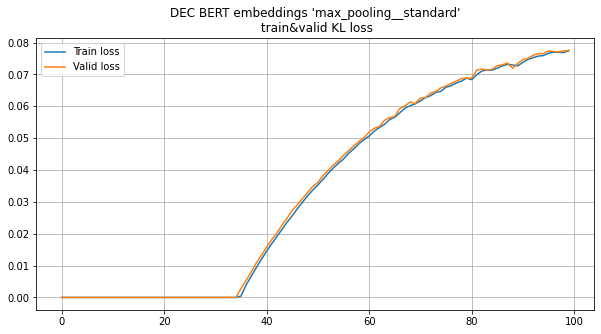

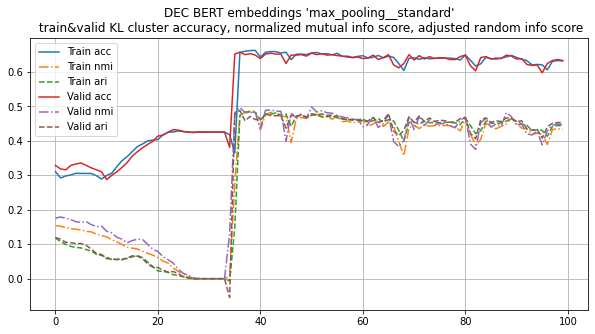

In [171]:
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.0)
model.load_state_dict(torch.load(r'./ae_weights/bertemb_train_5.pt'))

dec = DEC(autoencoder = model, n_clusters=7)
loss_fn = nn.KLDivLoss(reduction='batchmean')

optimizer = Adam(dec.parameters(), lr=1e-4)
# scheduler = StepLR(optimizer, step_size=60, gamma=0.1)

whole_train_valid_cycle(
    dec,
    None,
    optimizer,
    loss_fn,
    num_epochs = 100,
    # patience_threshold=10,
    device = device,
    save_best_params_as='./weights/bertemb_dec_weights_5',
    title="DEC BERT embeddings 'max_pooling__standard'\n train&valid KL"
)


In [172]:
print(
    dec.init_acc,
cluster_acc(
    num_labels.numpy(),
    dec(embeddings.to(device, dtype=torch.float32)).argmax(1).detach().cpu().numpy()
)
)

0.3294303797468354 0.6334899615548911


*We obtain here the same behavior. Don't think it is good to validate unsupervise clustering on such strange learning curve*

#### num. 6 'mean_pooling__layer'

In [181]:
embeddings = torch.Tensor(embdict['mean_pooling__layer'])

train_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=True)
valid_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=False)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=1024, shuffle=False, num_workers=0, pin_memory=True)

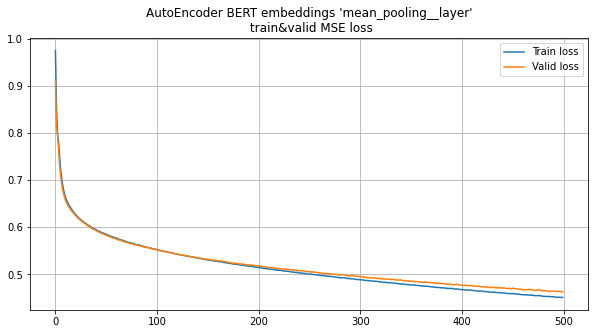

Model parameters saved to './ae_weights/bertemb_train_6_a.pt'


In [182]:
loss_fn = nn.MSELoss()
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.00)

optimizer = Adam(model.parameters(), lr=1e-4, )
# scheduler = StepLR(optimizer, step_size=100, gamma=10) 
# scheduler = MultiStepLR(optimizer, milestones=[50, 500], gamma=10)


whole_train_valid_cycle(
    model, 
    None,
    optimizer,
    loss_fn,
    num_epochs = 500, 
    device = device,
    patience_threshold = (10, 3),
    save_best_params_as = './ae_weights/bertemb_train_6_a.pt',
    title="AutoEncoder BERT embeddings 'mean_pooling__layer'\n train&valid MSE"
)

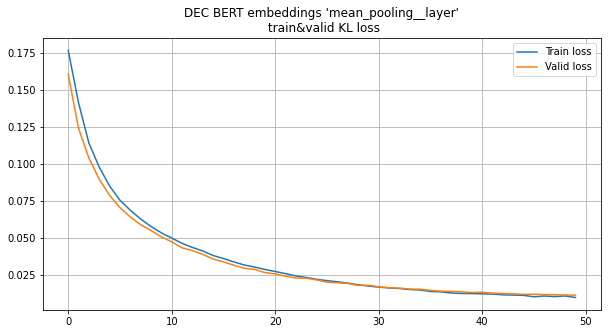

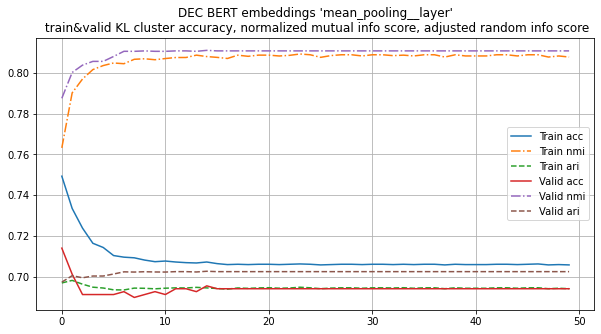

Model parameters saved to './weights/bertemb_dec_weights_6_a'


In [198]:
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.002)
model.load_state_dict(torch.load(r'./ae_weights/bertemb_train_6_a.pt'))

dec = DEC(autoencoder = model, n_clusters=7)
loss_fn = nn.KLDivLoss(reduction='batchmean')

optimizer = Adam(dec.parameters(), lr=1e-4)
# optimizer = SGD(dec.parameters(), lr=.0001, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=60, gamma=0.1)

whole_train_valid_cycle(
    dec,
    None,
    optimizer,
    loss_fn,
    num_epochs = 50,
    # patience_threshold=10,
    device = device,
    # save_best_params_as='./weights/bertemb_dec_weights_6_a.pt',
    title="DEC BERT embeddings 'mean_pooling__layer'\n train&valid KL"
)


In [218]:
dec.load_state_dict(torch.load(r'./weights/bertemb_dec_weights_6_a'))

dec_preds = dec(embeddings.to(device, dtype=torch.float32)).argmax(1).detach().cpu().numpy()

dec.state_dict()["assignment.centroids"].copy_(
                    torch.tensor(dec.kmeans.cluster_centers_)
                )
dec_init_preds = dec(embeddings.to(device, dtype=torch.float32)).argmax(1).detach().cpu().numpy()

np.save('./predictions/ae_kmeans_preds.npy', dec_init_preds)
np.save('./predictions/ae_kmeans_centroids.npy', dec.kmeans.cluster_centers_)
np.save('./predictions/dec_preds.npy', dec_preds)
np.save('./predictions/dec_centroids.npy', dec.assignment.centroids.detach().cpu().numpy())

print(
    'AE+KMeans accuracy on train dataset:', dec.init_acc, # train accuracy
    '\nAE+KMeans accuracy', cluster_acc(
        num_labels.numpy(),
        dec_init_preds,
    ),
    '\nDEC accuracy', cluster_acc(
        num_labels.numpy(),
        dec_preds,
    )
)

AE+KMeans accuracy on train dataset: 0.7493670886075949 
AE+KMeans accuracy 0.7058237220561013 
DEC accuracy 0.7058237220561013


In [220]:
model.load_state_dict(torch.load(r'./ae_weights/bertemb_train_6_a.pt'))

<All keys matched successfully>

In [222]:
loader = DataLoader(
    full_dataset,
    batch_size=256,
    pin_memory=False,
    shuffle=False,
)
xs, ys = [], []

for x, y in tqdm(loader, desc='Getting matrix'):
    x, y = x.to(device), y.to(device)
    xs.append(model.encoder(x).detach().cpu())
    ys.append(y)

xs = torch.cat(xs)
ys = torch.cat(ys)

Getting matrix: 100%|██████████| 28/28 [00:00<00:00, 49.06it/s]


In [225]:
centroids_ = dec.kmeans.cluster_centers_.copy()

In [232]:
# np.save('./predictions/features.npy', np.dot(xs, centroids_.T))

*Much better! The only problem is that there is no DEC (and thus IDEC) addition to the total accuracy - we could use simple autoencoder outputs! From the other hand, DEC efficiency was prooved on the MNIST dataset, which is well-balanced dataset with n=70000 samples, while our embeddings dataset has n=7023 unbalanced samples. We can try get an additional performance by augmenting our dataset*

# Dataset Augmentation

First of all, we should get a clear picture of what we want to get from our augmentation. In practice of unsupervised learning:
- We do not know which sample correlates to which class *a priori*
- But we do have initial guess of how many KMeans clusters do we have (n_clusters=7)
- To solve the problem of imbalanced classes during augmentation, we can somehow regularize augmentation of dominant classes (using intial cluster guess). Let's try to implement this idea.

In [20]:
txt_labels = np.load(r'./embeddings/embaug_txt_labels.npy', allow_pickle=True)

# np.save('./embeddings/embaug_txt_labels.npy', txt_labels)
# np.save('./embeddings/embaug_num_labels.npy', num_labels)

num_labels = np.load(r'./embeddings/embaug_num_labels.npy')
num_labels = torch.Tensor(num_labels)

# embaug_dict = np.load(r'.\embeddings\embaug_dict.npy', allow_pickle=True).item()

In [3]:
# np.save(r'./embeddings/embaug_meanpooling_layer.npy',embaug_dict['mean_pooling__layer'])

In [21]:
embeddings = torch.Tensor(embaug_dict['mean_pooling__layer'])

train_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=True)
valid_dataset = EmbeddingsDataset(embeddings, txt_labels, num_labels, train=False)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=1024, shuffle=False, num_workers=0, pin_memory=True)

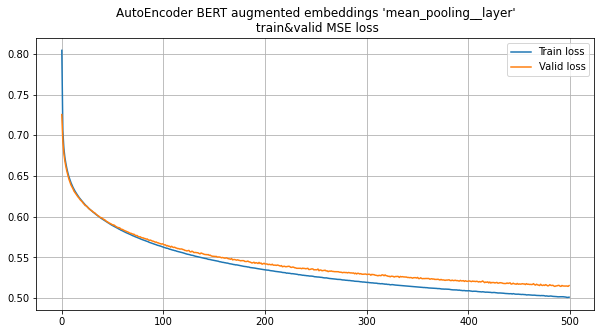

In [22]:
loss_fn = nn.MSELoss()
model = StackedAutoEncoder(dims=[768, 500, 500, 2000, 5], dropout_value=.00)

optimizer = Adam(model.parameters(), lr=1e-4, )
# scheduler = StepLR(optimizer, step_size=100, gamma=10) 
# scheduler = MultiStepLR(optimizer, milestones=[50, 500], gamma=10)


whole_train_valid_cycle(
    model, 
    None,
    optimizer,
    loss_fn,
    num_epochs = 500, 
    device = device,
    patience_threshold = (10, 3),
    save_best_params_as = './ae_weights/bertembaug_train_6.pt',
    title="AutoEncoder BERT augmented embeddings 'mean_pooling__layer'\n train&valid MSE"
)

## Run IDEC

In [ ]:
# dec.load_state_dict(torch.load(r'dec_weights.pt'))

<All keys matched successfully>

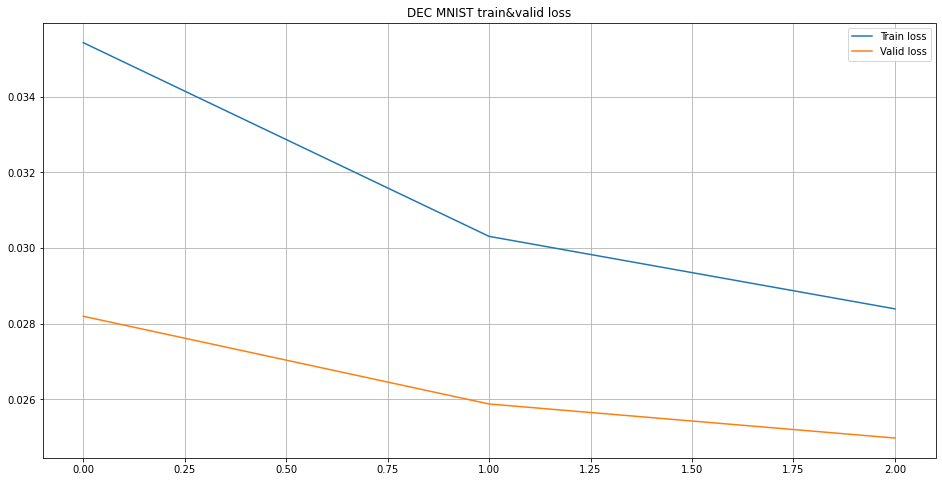

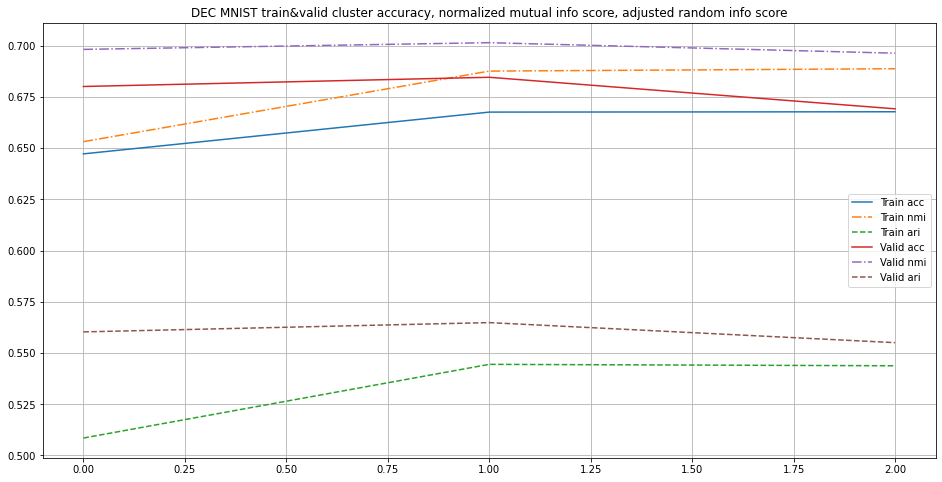

Train:   1%|          | 2/235 [00:00<00:14, 16.46it/s]


KeyboardInterrupt: 

In [16]:
model = StackedAutoEncoder(dims=[784, 500, 500, 2000, 10], dropout_value=.01)

model.load_state_dict(torch.load(r'best-model-parameters4mnist.pt'))

idec = IDEC(autoencoder=model)
loss_fn = IDEC_loss(gamma=.1)

optimizer = Adam(idec.parameters(), lr=1e-3,  betas = (.9, .999))
# optimizer = SGD(idec.parameters(), lr=0.01, momentum=0.9)

whole_train_valid_cycle(
    idec,
    None,
    optimizer,
    loss_fn,
    num_epochs = 100,
    delta_threshold = .1,
    # save_best_params_as = 'idec_weights.pt',
    device=device,
    title='DEC MNIST train&valid'
)

In [ ]:
# torch.save(idec.state_dict(), 'idec_weights.pt')

## Predicting cluster accuracy

In [155]:
def predict_cluster_accuracy(model, loader):
    model.to(device)
    targets, predicted = [], []
    kmeans_preds = []

    xs, ys = [], []

    for x, y in tqdm(loader, desc='Evaluate cluster accuracy'):
        x, y = x.to(device), y.to(device)
        x = x.reshape(-1, 28*28)
        
        q = model(x)

        y_pred = q.argmax(1)

        targets.append(y)
        predicted.append(y_pred)

        xs.append(model.encoder(x).detach().cpu())
        ys.append(y)

    xs = torch.cat(xs)
    ys = torch.cat(ys)

    with torch.no_grad():
        km = KMeans(n_clusters=10, n_init=20).fit(xs)


    return cluster_acc(
        torch.cat(targets).cpu().numpy(), 
        torch.cat(predicted).cpu().numpy()
    ), cluster_acc(
        ys.cpu().numpy(),
        km.labels_
    )

In [350]:
from ptsdae.sdae import StackedDenoisingAutoEncoder as Sdae
from ptdec.dec import DEC as __DEC

autoencoder = Sdae(
    [28 * 28, 500, 500, 2000, 10], final_activation=None
)
# def rename_attribute(obj, old_name, new_name):
#     obj.__dict__[new_name] = obj.__dict__.pop(old_name)

# from typing import OrderedDict
state_dict = OrderedDict((k.replace('linear','fc1') if 'encoder' or 'decoder' in k else k, v) for k, v in autoencoder.state_dict().items())

pt_dec = __DEC(cluster_number=10, hidden_dimension=10, encoder=autoencoder.encoder)

In [368]:
# pt_dec.load_state_dict(torch.load(r'b4_dec_train.pt'))
predict_cluster_accuracy(autoencoder, train_loader)

Evaluate cluster accuracy: 100%|██████████| 235/235 [00:24<00:00,  9.40it/s]


(0.43316666666666664, 0.5593666666666667)

In [355]:
pt_dec.state_dict().keys()

odict_keys(['encoder.0.linear.weight', 'encoder.0.linear.bias', 'encoder.1.linear.weight', 'encoder.1.linear.bias', 'encoder.2.linear.weight', 'encoder.2.linear.bias', 'encoder.3.linear.weight', 'encoder.3.linear.bias', 'assignment.cluster_centers'])